# Extraction of Spindles from Neocortex recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [1]:
from scipy import signal, stats
from scipy.signal import find_peaks, peak_widths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from ipyfilechooser import FileChooser
import ipywidgets as widgets

%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer, EventList, InMemoryEventSource
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

from mbTools import mbTools

In [2]:
dpath = ""
try:
    %store -r dpath
except:
    print("data path not in strore")
    dpath = os.path.expanduser("~")

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\GreenDotsOK\…

Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)


In [76]:
suffix='_AB'#'_AB'
sep = -5 # -3 if Baseline #-4 if CGP
animalIDPos = -4 # -3 if Baseline #-4 if CGP
dirPathComponents = os.path.normpath(dpath).split(os.sep)
mapPath = os.path.sep.join(dirPathComponents[:sep-1])
folder_base = os.path.sep.join(dirPathComponents[sep-1:])
mice = dirPathComponents[animalIDPos]
#os.chdir(mapPath)
print(mapPath)
print(folder_base)
print(mice)

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023
Gaelle\CGP\Purple\Baseline\session1\OpenEphys
Purple


In [41]:
filename3 = os.path.join(dpath,f'LFPwakeremoved{suffix}.npy')
filename2 = os.path.join(dpath,'RawDataChannelExtractedDS.npy')
EMGbooleaninput = os.path.join(dpath,f'EMGframeBoolean{suffix}.pkl')

EMGboolean = pd.read_pickle(EMGbooleaninput)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')

try:
    Channels = os.path.join(mapPath,f'LFPChannels_perMice.xlsx')
    allchannels = pd.read_excel(Channels)
    PFCch1=int(allchannels[mice][0].split(',')[0])
    PFCch2=int(allchannels[mice][0].split(',')[1])
    S1ch1=int(allchannels[mice][1].split(',')[0])
    S1ch2=int(allchannels[mice][1].split(',')[1])
    CA1ch1=int(allchannels[mice][2].split(',')[0])
    CA1ch2=int(allchannels[mice][2].split(',')[1])
except FileNotFoundError as e:
    print(mbTools.color.BOLD + mbTools.color.YELLOW)
    print(f"File {os.path.join(mapPath,f'LFPChannels_perMice.xlsx')} not found!")
    print("probably you are not Aurélie... or the path to access it is wrong.")
    print("In the first case, make sure the mapping is rightfully setup in the curent cell")
    print("In the second case, you can play with the 'sep' variable of cell 3, or directly change the path")
    print(mbTools.color.END)
    PFCch1=1
    PFCch2=None
    S1ch1=2
    S1ch2=None
    CA1ch1=21
    CA1ch2=22

PFC  =  All[:, PFCch1]-All[:, PFCch2] if PFCch2 is not None else All[:, PFCch1]
#CA1  =  All[:, CA1ch1]-All[:, CA1ch2] if CA1ch2 is not None else All[:, CA1ch1]
S1  =  All[:, S1ch1]-All[:, S1ch2] if S1ch2 is not None else All[:, S1ch1]
#CA1wakeremoved = LFPwakeremoved[:,CA1ch1]-LFPwakeremoved[:,CA1ch2] 
PFCwakeremoved = LFPwakeremoved[:,PFCch1]-LFPwakeremoved[:,PFCch2] 
S1wakeremoved = LFPwakeremoved[:,S1ch1]-LFPwakeremoved[:,S1ch2] 

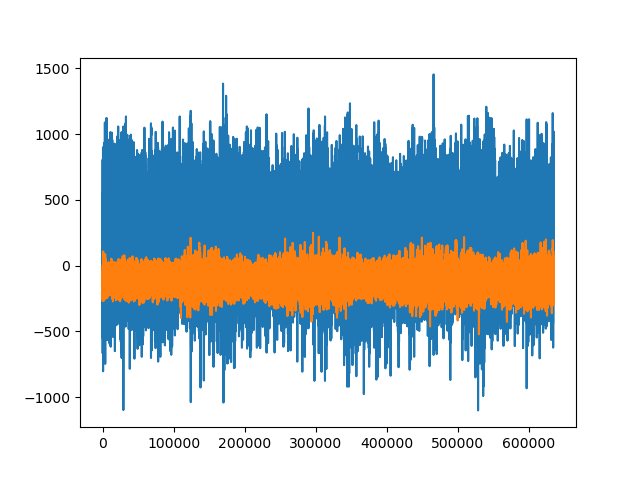

In [42]:
plt.close()
plt.plot(S1wakeremoved)
plt.plot(PFCwakeremoved)
plt.show()

# Band pass filter
        Spindles: 8-20 Hz

In [43]:
# Filtre parameter:
f_lowcut = 8.
f_hicut = 20.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_PFC = signal.filtfilt(b, a, PFC)
filt_PFCwakeremoved = signal.filtfilt(b, a, PFCwakeremoved)

filt_S1 = signal.filtfilt(b, a, S1)
filt_S1wakeremoved = signal.filtfilt(b, a, S1wakeremoved)


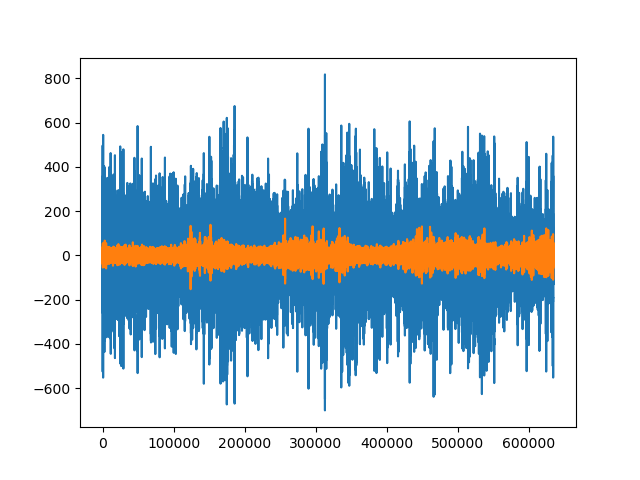

In [44]:
plt.close()
plt.plot(filt_S1wakeremoved)
plt.plot(filt_PFCwakeremoved)
plt.show()

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [57]:
# Parameter and computation of CWT
w = 10.
freq = np.linspace(8, 20, 24)
widths = w*fs / (2*freq*np.pi)
PFCNWcwt = signal.cwt(filt_PFCwakeremoved, signal.morlet2, widths, w=w)
S1NWcwt = signal.cwt(filt_S1wakeremoved, signal.morlet2, widths, w=w)

# Projection calculation PFC
absPFCNWcwt = np.absolute(PFCNWcwt)
proj_PFCNWcwt = np.sum(absPFCNWcwt, axis = 0)/24
sdproj_PFCcwt = np.std(proj_PFCNWcwt)
sd7proj_PFCcwt = sdproj_PFCcwt*7
sd3proj_PFCcwt = sdproj_PFCcwt*3

# Projection calculation S1
absS1NWcwt = np.absolute(S1NWcwt)
proj_S1NWcwt = np.sum(absS1NWcwt, axis = 0)/24
sdproj_S1cwt = np.std(proj_S1NWcwt)
sd7proj_S1cwt = sdproj_S1cwt*7
sd3proj_S1cwt = sdproj_S1cwt*3

Second on the signal for which wake times have been zeroed

In [46]:
#####################################
########        PFC         #########
#####################################
# Conservative boolean filtering of PFC filtered signal
BooleanCons = EMGboolean['BooleanConservative']
fPFCwake0C = filt_PFC.copy()
fPFCwake0C[BooleanCons] = 0
PFCwake0C = PFC.copy()
PFCwake0C[BooleanCons] = 0
# Liberal boolean filtering of PFC filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
fPFCwake0L = filt_PFC.copy()
fPFCwake0L[BooleanLib] = 0
PFCwake0L = PFC.copy()
PFCwake0L[BooleanLib] = 0

# Computation of CWT
PFCcwtWake0cons = signal.cwt(fPFCwake0C, signal.morlet2, widths, w=w)
PFCcwtWake0lib = signal.cwt(fPFCwake0L, signal.morlet2, widths, w=w)

# Projection calculation
absPFCW0Ccwt = np.absolute(PFCcwtWake0cons)
proj_PFCW0Ccwt = np.sum(absPFCW0Ccwt, axis = 0)/24
absPFCW0Lcwt = np.absolute(PFCcwtWake0lib)
proj_PFCW0Lcwt = np.sum(absPFCW0Lcwt, axis = 0)/24



#####################################
########         S1         #########
#####################################
# Conservative boolean filtering of S1 filtered signal
BooleanCons = EMGboolean['BooleanConservative']
fS1wake0C = filt_S1.copy()
fS1wake0C[BooleanCons] = 0
S1wake0C = S1.copy()
S1wake0C[BooleanCons] = 0
# Liberal boolean filtering of S1 filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
fS1wake0L = filt_S1.copy()
fS1wake0L[BooleanLib] = 0
S1wake0L = S1.copy()
S1wake0L[BooleanLib] = 0

# Computation of CWT
S1cwtWake0cons = signal.cwt(fS1wake0C, signal.morlet2, widths, w=w)
S1cwtWake0lib = signal.cwt(fS1wake0L, signal.morlet2, widths, w=w)

# Projection calculation
absS1W0Ccwt = np.absolute(S1cwtWake0cons)
proj_S1W0Ccwt = np.sum(absS1W0Ccwt, axis = 0)/24
absS1W0Lcwt = np.absolute(S1cwtWake0lib)
proj_S1W0Lcwt = np.sum(absS1W0Lcwt, axis = 0)/24

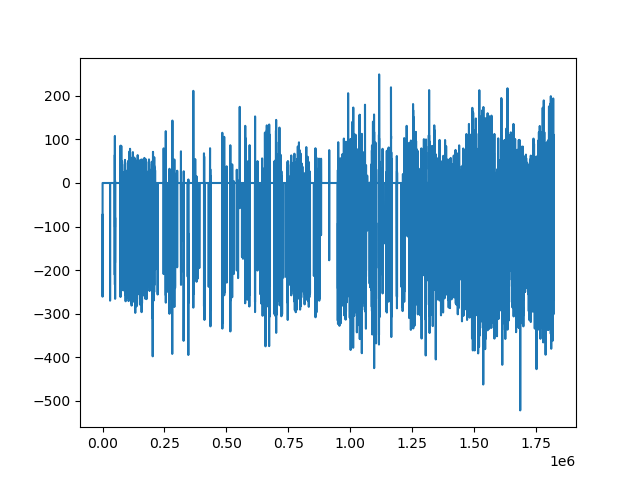

In [49]:
plt.close()
plt.plot(PFCwake0L)
plt.show()

### Display subset 

Not necessary cell to run

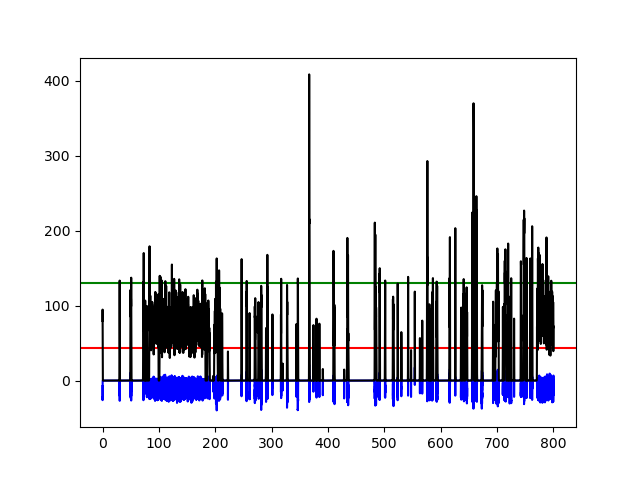

In [59]:
# Defining subset
start = 00000
end = 800000

times = np.arange(0, S1.size/fs, 1./fs)
tt = times[start:end]
Cortext = PFCwake0L[start:end]/10
#Cortexcwtt = PFCNWcwt[:, start:end]
proj_Cortexcwtt = proj_PFCW0Lcwt[start:end]

plt.close('all')
plt.axhline(sdproj_PFCcwt, color='r') # horizontal
plt.axhline(sd3proj_PFCcwt, color='g') # horizontal
plt.plot(tt, Cortext,'b')
plt.plot(tt, proj_Cortexcwtt,'k')
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(PFCcwtt), cmap='viridis', shading='gouraud')
#plt.plot(tt, PFCt)
#plt.show()


Display with ephyviewer, not needed

## Extracting Spindles and determining main properties 

First extraction of spindle peaks, initiation, end and width

In [62]:
structure = "PFC"
cortex = eval(structure)
proj_cortex = proj_S1W0Lcwt
proj_cortexC = proj_S1W0Ccwt
sd_proj_cortex = sd3proj_S1cwt
lib_wake0_cortex = S1cwtWake0lib
filt_cortex = filt_S1

# 7 sd threshold
peaks, properties = find_peaks(proj_cortex, prominence=1, width=200, height=sd_proj_cortex)
properties["prominences"], properties["widths"]

# Spindles boundaries taken at 70% from peak of intensity. This means that the spindles with small amplitude will be longer than the big ones.
results_width = peak_widths(proj_cortex, peaks, rel_height=0.6)

# Organise results in numpy array
peaks2 = peaks.reshape(len(peaks),1)
npresults_width = np.array(results_width).reshape(4,-1)
Spindle_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()
peaks.shape

(349,)

Second extraction of main frequency and power 

In [63]:
projMaxP_cwtmg = np.max(lib_wake0_cortex, axis = 0)
projMaxF_cwtmg = np.argmax(lib_wake0_cortex, axis = 0)/2 + 8
projMaxP_cwtmg.shape

nb_Spindles = len(peaks)
data = np.zeros((nb_Spindles,4))

for tt in np.arange(nb_Spindles):
    Spindle_start = int(Spindle_prop[3,tt])
    Spindle_stop = int(Spindle_prop[4,tt])
    Spindle_MaxP = projMaxP_cwtmg[Spindle_start:Spindle_stop]
    Spindle_MaxF = projMaxF_cwtmg[Spindle_start:Spindle_stop]
    data[tt, 0] = max(Spindle_MaxF).round()
    data[tt, 1] = max(Spindle_MaxP).round()
    data[tt, 2] = round(sum(Spindle_MaxF)/len(Spindle_MaxF))
    data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))

param_Spindle = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
tSpindle_prop = Spindle_prop.transpose()
pd_prop_Spindle = pd.DataFrame(tSpindle_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
pd_tokeep = pd.DataFrame(np.ones(nb_Spindles).astype(bool), columns = ['toKeep'])
All_Spindle = pd.concat([pd_tokeep,pd_prop_Spindle, param_Spindle], axis=1)

C:\Users\Manip2\AppData\Local\Temp\ipykernel_45648\1655139010.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(Spindle_MaxP).round()
C:\Users\Manip2\AppData\Local\Temp\ipykernel_45648\1655139010.py:16: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))
C:\Users\Manip2\AppData\Local\Temp\ipykernel_45648\1655139010.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(Spindle_MaxP)/len(Spindle_MaxP))


apparently, the file \\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\Purple\Baseline\session1\OpenEphys\Spindlesproperties_PFC_AB.pkl doesn't exist yet so we are saving it


save_all_settings


### Display

ephys viewer to check Spindle detection

In [70]:
%gui qt
app = mkQApp()

#Create one data source with 3 event channel
all_events = []
conditions = ['All','Good','Bad']
for c,cond in enumerate(conditions):
    match cond:
        case 'All':
            selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
        case 'Good':
            selection = "All_Spindle['toKeep']"
        case 'Bad':
            selection = "~All_Spindle['toKeep']"
    ev_times = All_Spindle.loc[pd.eval(selection),'peak time'].values/1000
    ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
    all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
source_ev = InMemoryEventSource(all_events=all_events)


sample_rate = 1000.
t_start = 0.

combined = np.stack([cortex, filt_cortex, proj_cortexC, proj_cortex], axis = 1)

Spindle_peak = peaks
Spindle_start = Spindle_prop[3,:].astype(int)
Spindle_end = Spindle_prop[4,:].astype(int)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
#and asign them to some channels each
scatter_channels = {0: [1, 2], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
view1.auto_scale()

nCh = len(view1.by_channel_params.children())
mult = 4
for ch in range(nCh):
    match ch%mult:
        case 0: # raw traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = 2.5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.05
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ffffff'
        case 1: # filtered traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#0055ff'
        case 2: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ff5500'
        case 3: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 3*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ffffff'
view1.params['ylim_max']=3*int((nCh+1)/mult)
view1.params['ylim_min']=0

view2 = EventList(source=source_ev, name='event')


#put this viewer in the main window
win.add_view(view1)
win.add_view(view2, location='bottom',  orientation='horizontal')

#Run
win.show()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s


save_all_settings


#### Select and deselect spindles

In [65]:
def clicked(arg):
    selectedEvent = view2.list_widget.currentItem().text()
    selectedSpindle = int(selectedEvent.split('spindle')[1])
    #print(selectedSpindle)
    match arg.description:
        case 'Keep spindle':
            All_Spindle.loc[selectedSpindle,'toKeep']=True
            print(f'Spindle {selectedSpindle} restored')
        case 'Discard spindle':
            All_Spindle.loc[selectedSpindle,'toKeep']=False
            print(f'Spindle {selectedSpindle} discarded')
    #save modif
    All_Spindle.to_pickle(filename2)
    All_Spindle.to_csv(filename3, sep = ',')
    #Create one data source with 3 event channel
    all_events = []
    conditions = ['All','Good','Bad']
    for c,cond in enumerate(conditions):
        match cond:
            case 'All':
                selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
            case 'Good':
                selection = "All_Spindle['toKeep']"
            case 'Bad':
                selection = "~All_Spindle['toKeep']"
        ev_times = All_Spindle.loc[pd.eval(selection),'peak time'].values/1000
        ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
        all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
    source_ev = InMemoryEventSource(all_events=all_events)
    view2.source = source_ev
    view2.refresh_list(view2.combo.currentIndex())

button_Good = widgets.Button(description = 'Keep spindle')   
button_Good.on_click(clicked)

button_Bad = widgets.Button(description = 'Discard spindle')   
button_Bad.on_click(clicked)

display(button_Good, button_Bad)

Button(description='Keep spindle', style=ButtonStyle())

Button(description='Discard spindle', style=ButtonStyle())

Spindle 6 discarded
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0016345977783203125 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for event 0.0 s
refresh duration for  0.

### Store the results in All_Spindle_prop pd dataframe and save as pkl/csv for post processing.

End of Notebook. 

In [69]:
filenameOutput2 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.pkl')
filenameOutput3 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.csv')

if os.path.isfile(filenameOutput2):
    print(f'carreful, a file {filenameOutput2} already exists. Now trying to import it. Make sure it properly worked as it is not yet tested')
    import pandas as pd
    All_Spindle = pd.read_pickle(filenameOutput2)
    print(All_Spindle)
else:
    print(f"apparently, the file {filenameOutput2} doesn't exist yet so we are saving it")
    All_Spindle.to_pickle(filenameOutput2)
    All_Spindle.to_csv(filenameOutput3, sep = ',')

carreful, a file \\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\Purple\Baseline\session1\OpenEphys\Spindlesproperties_PFC_AB.pkl already exists. Now trying to import it. Make sure it properly worked as it is not yet tested
     toKeep  peak time  Duration  peak amp  start time   end time  Max freq  \
0      True    49719.0     937.0     649.0     49440.0    50376.0      20.0   
1     False    50834.0     409.0     768.0     50546.0    50955.0      20.0   
2     False    72504.0     738.0     540.0     72060.0    72798.0      20.0   
3      True    78883.0     907.0     375.0     78172.0    79079.0      20.0   
4      True    84980.0     992.0     604.0     84268.0    85260.0      20.0   
..      ...        ...       ...       ...         ...        ...       ...   
344    True  1817906.0     359.0     611.0   1817730.0  1818088.0      20.0   
345    True  1818568.0     265.0     692.0   1818434.0  1818698.0      20.0   
346    True  1819211.0     299.0 